# Assignment 2 - Gesture Based UI

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


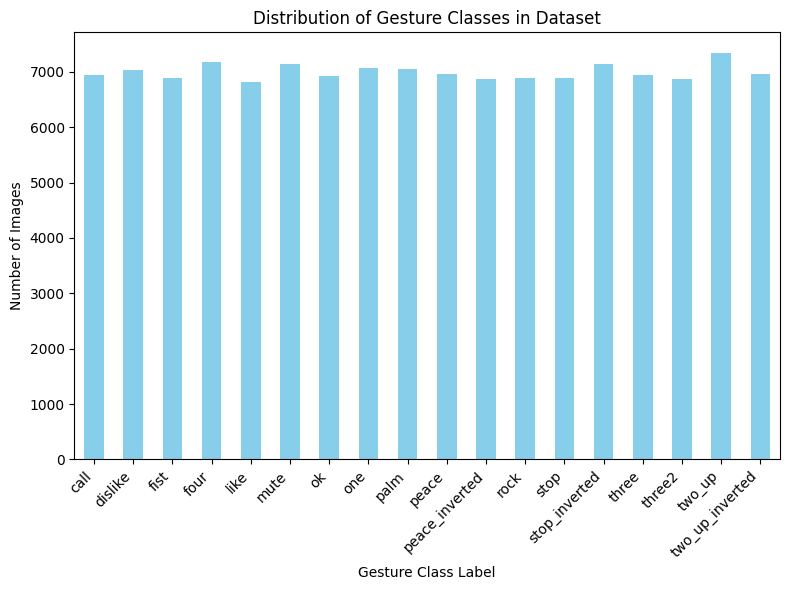

In [2]:
import matplotlib.pyplot as plt
from os import listdir

# Replace 'data_directory' with the path to your dataset root directory
data_directory = 'hagridset'

# Initialize an empty dictionary to store class labels and image counts
class_counts = {}

# Iterate through subdirectories in the data directory
for directory in listdir(data_directory):
  # Assuming subdirectories represent gesture classes
  class_label = directory

  # Count the number of images in the current class directory
  image_count = len([name for name in listdir(os.path.join(data_directory, directory))
                    if os.path.isfile(os.path.join(data_directory, directory, name))])

  # Add the class label and image count to the dictionary
  class_counts[class_label] = image_count

# Convert the dictionary to a pandas Series for visualization
class_series = pd.Series(class_counts)

# Create a bar chart to visualize the distribution
plt.figure(figsize=(8, 6))
class_series.plot(kind='bar', color='skyblue')
plt.xlabel('Gesture Class Label')
plt.ylabel('Number of Images')
plt.title('Distribution of Gesture Classes in Dataset')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()

# Save the plot as an image (optional)
# plt.savefig('gesture_class_distribution.png')

# Display the plot
plt.show()


# Model: CNN From Scratch - Base Model - Default Image Colour
Image size = 128 x 128<br/>
Image colour = RGB<br/>



In [17]:
# Define constants
IMAGE_SIZE = (128, 128) #Image size of 128 x 128
BATCH_SIZE = 32
DATASET_PATH = "hagridset"
SEED = 399177 #G00399177

In [18]:
# This code sets up two TensorFlow Keras image datasets for training and validation/testing. The `train_dataset` is created from the 
# `DATASET_PATH` directory, with a 70/30 split for training and validation data. The `validation_and_test_dataset` is also created from
# the `DATASET_PATH` directory, with the same 70/30 split. The `test_dataset` is then created by taking the last 2/3 of the `validation_and_test_dataset`,
# and the `validation_dataset` is created by skipping the last 2/3 of the `validation_and_test_dataset`.
train_dataset = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE, validation_split=0.3
                                                           , subset='training', label_mode='categorical', 
                                                           seed=SEED, batch_size=BATCH_SIZE)

validation_and_test_dataset = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE, validation_split=0.3
                                                           , subset='validation',label_mode='categorical',
                                                           seed=SEED, batch_size=BATCH_SIZE)

val_batches = tf.data.experimental.cardinality(validation_and_test_dataset)

test_dataset = validation_and_test_dataset.take((2*val_batches) // 3)
validation_dataset = validation_and_test_dataset.skip((2*val_batches) // 3) 


Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [19]:
# Get the number of classes from the data generator
NUM_CLASSES = len(train_dataset.class_names)
print("Classes: ",NUM_CLASSES)

Classes:  18


In [20]:
# CNN model from scratch
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1],3)))
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)       

In [22]:

# Configures an EarlyStopping callback for a Keras model.

# This callback monitors the validation loss during training and stops the training
# if the validation loss does not improve for 5 epochs. It also restores the
# weights of the model to the best performing weights during training.

# Args:
#     monitor (str): The metric to monitor for early stopping. In this case, it is
#         set to 'val_loss', which means the validation loss.
#     patience (int): The number of epochs to wait before stopping the training if
#         the monitored metric does not improve.
#     restore_best_weights (bool): If True, the model will be restored to the
#         weights that had the best value of the monitored metric.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [24]:
# Trains the model on the provided training dataset and evaluates it on the validation dataset. The training runs for 10 epochs and uses the provided callback function to monitor and control the training process.

# Parameters:
# - train_dataset (tf.data.Dataset): The training dataset.
# - validation_dataset (tf.data.Dataset): The validation dataset.
# - epochs (int): The number of training epochs.
# - callbacks (list): A list of callback functions to use during training.
history = model.fit(train_dataset,  validation_data=(validation_dataset), epochs=10, callbacks=[callback])

Epoch 1/10
2755/2755 [==============================] - 30s 11ms/step - loss: 1.3861 - accuracy: 0.5529 - val_loss: 1.2855 - val_accuracy: 0.5912
Epoch 2/10
2755/2755 [==============================] - 30s 11ms/step - loss: 1.0073 - accuracy: 0.6733 - val_loss: 1.2652 - val_accuracy: 0.6146
Epoch 3/10
2755/2755 [==============================] - 29s 11ms/step - loss: 0.7731 - accuracy: 0.7476 - val_loss: 1.3140 - val_accuracy: 0.6301
Epoch 4/10
2755/2755 [==============================] - 31s 11ms/step - loss: 0.5914 - accuracy: 0.8054 - val_loss: 1.4964 - val_accuracy: 0.6196
Epoch 5/10
2755/2755 [==============================] - 30s 11ms/step - loss: 0.4561 - accuracy: 0.8482 - val_loss: 1.7483 - val_accuracy: 0.6115
Epoch 6/10
2755/2755 [==============================] - 29s 11ms/step - loss: 0.3625 - accuracy: 0.8779 - val_loss: 2.1828 - val_accuracy: 0.6043
Epoch 7/10
2755/2755 [==============================] - 29s 10ms/step - loss: 0.2947 - accuracy: 0.9004 - val_loss: 2.2645 -

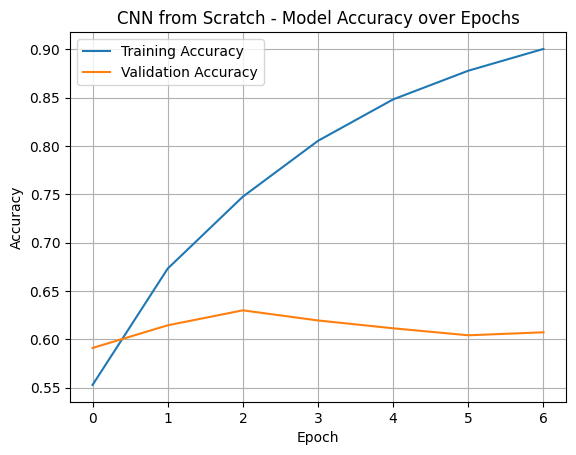

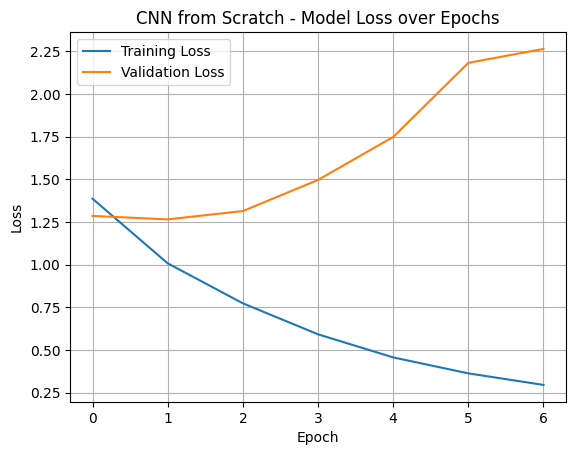

In [95]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN from Scratch - Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN from Scratch - Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Model1: CNN from Scratch - RGB Images - More Convolutional Layers and Increased Filters

- The previous base model could improve if it was given tena dditional epochs, but lets keep it to ten and see if we can improve it within those then epochs.

In [26]:
# Define constants
IMAGE_SIZE1 = (128, 128) #Image size of 128 x 128
BATCH_SIZE1 = 32
DATASET_PATH = "hagridset"
SEED = 399177 #G00399177

In [27]:
train_dataset1 = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE1, validation_split=0.3
                                                           , subset='training', label_mode='categorical', 
                                                           seed=SEED, batch_size=BATCH_SIZE1)

validation_and_test_dataset1 = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE1, validation_split=0.3
                                                           , subset='validation',label_mode='categorical',
                                                           seed=SEED, batch_size=BATCH_SIZE1)

val_batches1 = tf.data.experimental.cardinality(validation_and_test_dataset1)

test_dataset1 = validation_and_test_dataset1.take((2*val_batches1) // 3)
validation_dataset1 = validation_and_test_dataset1.skip((2*val_batches1) // 3) 


Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [28]:
# Get the number of classes from the data generator
NUM_CLASSES = len(train_dataset1.class_names)
print("Classes: ",NUM_CLASSES)

Classes:  18


In [29]:
# CNN model from scratch
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.Input(shape=(IMAGE_SIZE1[0], IMAGE_SIZE1[1],3)))
model1.add(layers.Rescaling(1./255))
model1.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model1.add(layers.MaxPooling2D())
model1.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model1.add(layers.MaxPooling2D())
model1.add(layers.Conv2D(48, 3, padding='same', activation='relu'))
model1.add(layers.MaxPooling2D())
model1.add(layers.Conv2D(96, 3, padding='same', activation='relu'))
model1.add(layers.MaxPooling2D())
model1.add(layers.GlobalAveragePooling2D())
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [30]:
#model1.fit(train_dataset1,  validation_data=(validation_dataset1), epochs=10, callbacks=[callback])
history1 = model1.fit(train_dataset1, validation_data=(validation_dataset1), epochs=10, callbacks=[callback])

Epoch 1/10
2755/2755 [==============================] - 40s 14ms/step - loss: 2.6243 - accuracy: 0.1426 - val_loss: 2.1821 - val_accuracy: 0.2767
Epoch 2/10
2755/2755 [==============================] - 41s 15ms/step - loss: 1.7516 - accuracy: 0.4267 - val_loss: 1.3210 - val_accuracy: 0.5726
Epoch 3/10
2755/2755 [==============================] - 42s 15ms/step - loss: 1.1616 - accuracy: 0.6228 - val_loss: 1.0105 - val_accuracy: 0.6773
Epoch 4/10
2755/2755 [==============================] - 42s 15ms/step - loss: 0.8946 - accuracy: 0.7131 - val_loss: 0.8164 - val_accuracy: 0.7398
Epoch 5/10
2755/2755 [==============================] - 40s 15ms/step - loss: 0.7363 - accuracy: 0.7645 - val_loss: 0.7032 - val_accuracy: 0.7739
Epoch 6/10
2755/2755 [==============================] - 42s 15ms/step - loss: 0.6304 - accuracy: 0.7981 - val_loss: 0.6213 - val_accuracy: 0.7999
Epoch 7/10
2755/2755 [==============================] - 40s 15ms/step - loss: 0.5534 - accuracy: 0.8227 - val_loss: 0.5472 -

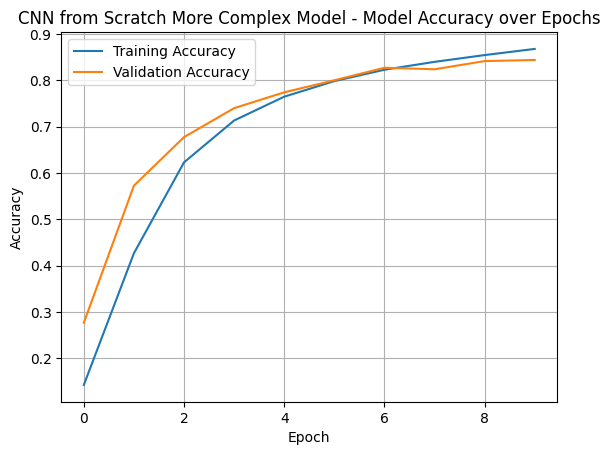

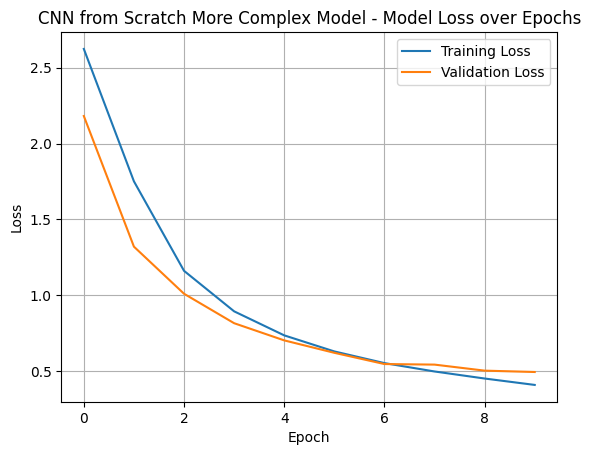

In [32]:
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN from Scratch More Complex Model - Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('CNN from Scratch More Complex Model - Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Model2: CNN from Scatch - Grayscale Images

In [41]:
# Define constants
IMAGE_SIZE2 = (128, 128) #Image size of 128 x 128
BATCH_SIZE2 = 32
DATASET_PATH = "hagridset"
SEED = 399177 #G00399177

In [42]:
# This code sets up two TensorFlow Keras image datasets for training and validation/testing. The `train_dataset` is created from the 
# `DATASET_PATH` directory, with a 70/30 split for training and validation data. The `validation_and_test_dataset` is also created from
# the `DATASET_PATH` directory, with the same 70/30 split. The `test_dataset` is then created by taking the last 2/3 of the `validation_and_test_dataset`,
# and the `validation_dataset` is created by skipping the last 2/3 of the `validation_and_test_dataset`.
train_dataset_grayscale = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            color_mode = "grayscale",
                                                            image_size=IMAGE_SIZE2, validation_split=0.3
                                                           , subset='training', label_mode='categorical', 
                                                           seed=SEED, batch_size=BATCH_SIZE2)
NUM_CLASSES = len(train_dataset_grayscale.class_names)
CLASS_NAMES = train_dataset_grayscale.class_names

validation_and_test_dataset_grayscale = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            color_mode="grayscale",
                                                            image_size=IMAGE_SIZE2, validation_split=0.3
                                                           , subset='validation',label_mode='categorical',
                                                           seed=SEED, batch_size=BATCH_SIZE2)

val_batches = tf.data.experimental.cardinality(validation_and_test_dataset_grayscale)

test_dataset_grayscale = validation_and_test_dataset_grayscale.take((2*val_batches) // 3)

validation_dataset_grayscale = validation_and_test_dataset_grayscale.skip((2*val_batches) // 3)

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [43]:
# CNN model from scratch
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.Input(shape=(IMAGE_SIZE2[0], IMAGE_SIZE2[1],1)))
model2.add(layers.Rescaling(1./255))
model2.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(48, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(96, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.GlobalAveragePooling2D())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [44]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [45]:
history2 = model2.fit(train_dataset_grayscale,  validation_data=(validation_dataset_grayscale), epochs=10, callbacks=[callback])

Epoch 1/10
2755/2755 [==============================] - 36s 13ms/step - loss: 2.6782 - accuracy: 0.1281 - val_loss: 2.3608 - val_accuracy: 0.2282
Epoch 2/10
2755/2755 [==============================] - 35s 13ms/step - loss: 2.1296 - accuracy: 0.2978 - val_loss: 1.8582 - val_accuracy: 0.3847
Epoch 3/10
2755/2755 [==============================] - 35s 13ms/step - loss: 1.7002 - accuracy: 0.4410 - val_loss: 1.5950 - val_accuracy: 0.4910
Epoch 4/10
2755/2755 [==============================] - 35s 13ms/step - loss: 1.3840 - accuracy: 0.5498 - val_loss: 1.3773 - val_accuracy: 0.5652
Epoch 5/10
2755/2755 [==============================] - 34s 12ms/step - loss: 1.1557 - accuracy: 0.6255 - val_loss: 1.1480 - val_accuracy: 0.6332
Epoch 6/10
2755/2755 [==============================] - 34s 12ms/step - loss: 0.9973 - accuracy: 0.6785 - val_loss: 0.9946 - val_accuracy: 0.6853
Epoch 7/10
2755/2755 [==============================] - 34s 12ms/step - loss: 0.8792 - accuracy: 0.7153 - val_loss: 0.9172 -

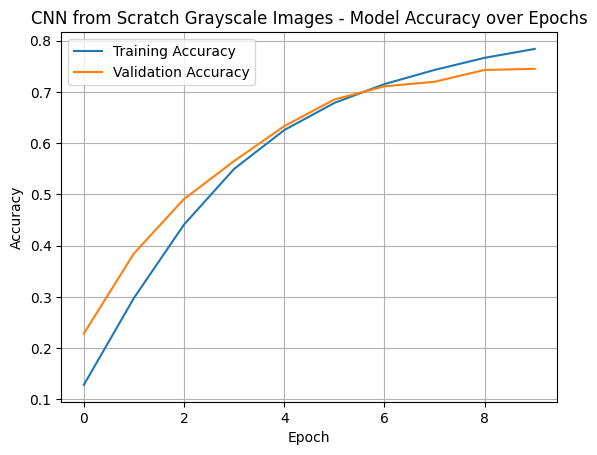

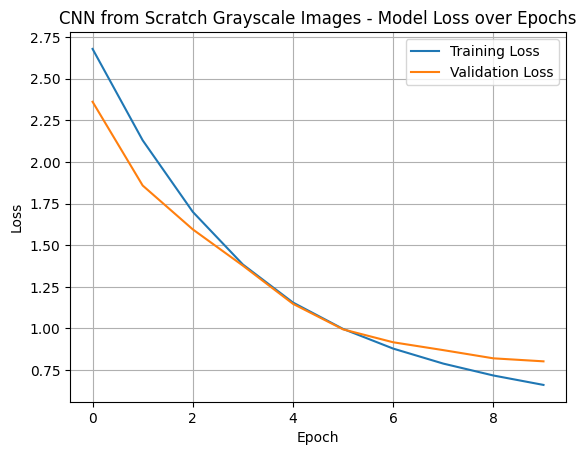

In [46]:
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN from Scratch Grayscale Images - Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('CNN from Scratch Grayscale Images - Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 48)       

# Model3: CNN from Scratch - Data Augmentation using RGB and model1's model architecture

In [48]:
# Define constants
IMAGE_SIZE3 = (128, 128) #Image size of 128 x 128
BATCH_SIZE3 = 32
DATASET_PATH = "hagridset"
SEED = 399177 #G00399177

In [49]:
# This code sets up two TensorFlow Keras image datasets for training and validation/testing. The `train_dataset` is created from the 
# `DATASET_PATH` directory, with a 70/30 split for training and validation data. The `validation_and_test_dataset` is also created from
# the `DATASET_PATH` directory, with the same 70/30 split. The `test_dataset` is then created by taking the last 2/3 of the `validation_and_test_dataset`,
# and the `validation_dataset` is created by skipping the last 2/3 of the `validation_and_test_dataset`.
train_dataset3 = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE3, validation_split=0.3
                                                           , subset='training', label_mode='categorical', 
                                                           seed=SEED, batch_size=BATCH_SIZE3)
NUM_CLASSES = len(train_dataset3.class_names)
CLASS_NAMES = train_dataset3.class_names

validation_and_test_dataset3 = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE3, validation_split=0.3
                                                           , subset='validation',label_mode='categorical',
                                                           seed=SEED, batch_size=BATCH_SIZE3)

val_batches3 = tf.data.experimental.cardinality(validation_and_test_dataset3)

test_dataset3 = validation_and_test_dataset3.take((2*val_batches3) // 3)

validation_dataset3 = validation_and_test_dataset3.skip((2*val_batches3) // 3)

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [50]:
data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

In [51]:
# CNN model from scratch
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.Input(shape=(IMAGE_SIZE3[0], IMAGE_SIZE3[1],3)))
model3.add(data_augmentation_layers)
model3.add(layers.Rescaling(1./255))
model3.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(48, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(96, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.GlobalAveragePooling2D())
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
model3.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [52]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [53]:
history3 = model3.fit(train_dataset3,  validation_data=(validation_dataset3), epochs=10, callbacks=[callback])

Epoch 1/10
2755/2755 [==============================] - 148s 53ms/step - loss: 2.7759 - accuracy: 0.1002 - val_loss: 2.5522 - val_accuracy: 0.1675
Epoch 2/10
2755/2755 [==============================] - 147s 53ms/step - loss: 2.3474 - accuracy: 0.2383 - val_loss: 1.9609 - val_accuracy: 0.3507
Epoch 3/10
2755/2755 [==============================] - 146s 53ms/step - loss: 1.7863 - accuracy: 0.4160 - val_loss: 1.4261 - val_accuracy: 0.5373
Epoch 4/10
2755/2755 [==============================] - 146s 53ms/step - loss: 1.4168 - accuracy: 0.5392 - val_loss: 1.0833 - val_accuracy: 0.6527
Epoch 5/10
2755/2755 [==============================] - 145s 53ms/step - loss: 1.1832 - accuracy: 0.6152 - val_loss: 0.9462 - val_accuracy: 0.6966
Epoch 6/10
2755/2755 [==============================] - 144s 52ms/step - loss: 1.0249 - accuracy: 0.6698 - val_loss: 0.8500 - val_accuracy: 0.7221
Epoch 7/10
2755/2755 [==============================] - 144s 52ms/step - loss: 0.9168 - accuracy: 0.7046 - val_loss: 0

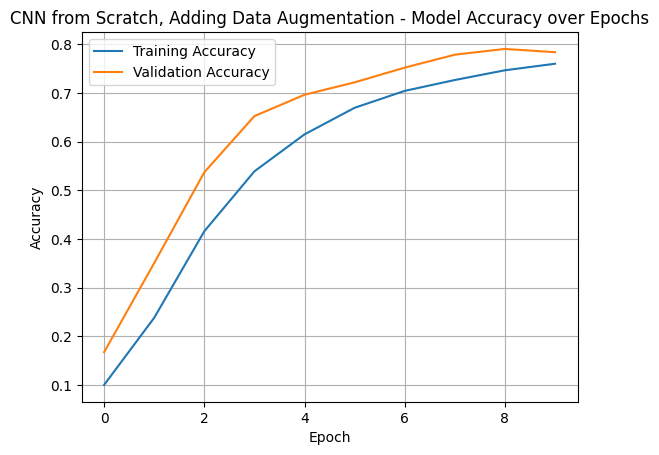

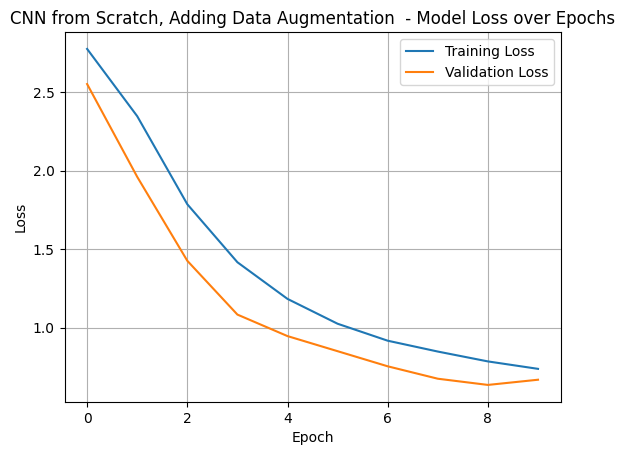

In [54]:
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN from Scratch, Adding Data Augmentation - Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('CNN from Scratch, Adding Data Augmentation  - Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Modeltf: Transfer Learning - 128x128 Image Size with Data Augmentation

In [75]:
# Define constants
IMAGE_SIZE_TRANSFERLEARNING = (128, 128)
BATCH_SIZE_TF = 32
DATASET_PATH = "hagridset"
SEED = 399177 #G00399177

In [76]:
# This code sets up two TensorFlow Keras image datasets for training and validation/testing. The `train_dataset` is created from the 
# `DATASET_PATH` directory, with a 70/30 split for training and validation data. The `validation_and_test_dataset` is also created from
# the `DATASET_PATH` directory, with the same 70/30 split. The `test_dataset` is then created by taking the last 2/3 of the `validation_and_test_dataset`,
# and the `validation_dataset` is created by skipping the last 2/3 of the `validation_and_test_dataset`.
train_datasettf = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE_TRANSFERLEARNING, validation_split=0.3
                                                           , subset='training', label_mode='categorical', 
                                                           seed=SEED, batch_size=BATCH_SIZE_TF)
NUM_CLASSES_TF = len(train_datasettf.class_names)
CLASS_NAMES_TF = train_datasettf.class_names

validation_and_test_datasettf = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE_TRANSFERLEARNING, validation_split=0.3
                                                           , subset='validation',label_mode='categorical',
                                                           seed=SEED, batch_size=BATCH_SIZE_TF)

val_batchestf = tf.data.experimental.cardinality(validation_and_test_datasettf)

test_datasettf = validation_and_test_datasettf.take((2*val_batchestf) // 3)

validation_datasettf = validation_and_test_datasettf.skip((2*val_batchestf) // 3)

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [77]:
data_augmentation_layerstf = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

In [78]:
inputs = tf.keras.Input(shape=(IMAGE_SIZE_TRANSFERLEARNING[0], IMAGE_SIZE_TRANSFERLEARNING[1],3))

In [79]:
model_transferlearning = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMAGE_SIZE_TRANSFERLEARNING[0], IMAGE_SIZE_TRANSFERLEARNING[1],3),
    include_top=False)

model_transferlearning.trainable = False
x = data_augmentation_layerstf(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = model_transferlearning(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES_TF)(x)
modeltf = tf.keras.Model(inputs, outputs)

In [80]:
modeltf.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [81]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [82]:
historytf = modeltf.fit(train_datasettf,  validation_data=(validation_datasettf), epochs=10, callbacks=[callback])

Epoch 1/10
2755/2755 [==============================] - 186s 67ms/step - loss: 3.2087 - accuracy: 0.2971 - val_loss: 1.8142 - val_accuracy: 0.4543
Epoch 2/10
2755/2755 [==============================] - 185s 67ms/step - loss: 2.2683 - accuracy: 0.3473 - val_loss: 1.8340 - val_accuracy: 0.4494
Epoch 3/10
2755/2755 [==============================] - 185s 67ms/step - loss: 2.2662 - accuracy: 0.3465 - val_loss: 1.8457 - val_accuracy: 0.4435
Epoch 4/10
2755/2755 [==============================] - 181s 66ms/step - loss: 2.2689 - accuracy: 0.3474 - val_loss: 1.8028 - val_accuracy: 0.4534
Epoch 5/10
2755/2755 [==============================] - 179s 65ms/step - loss: 2.2654 - accuracy: 0.3470 - val_loss: 1.8696 - val_accuracy: 0.4416
Epoch 6/10
2755/2755 [==============================] - 180s 65ms/step - loss: 2.2552 - accuracy: 0.3482 - val_loss: 1.7850 - val_accuracy: 0.4551
Epoch 7/10
2755/2755 [==============================] - 177s 64ms/step - loss: 2.2635 - accuracy: 0.3483 - val_loss: 1

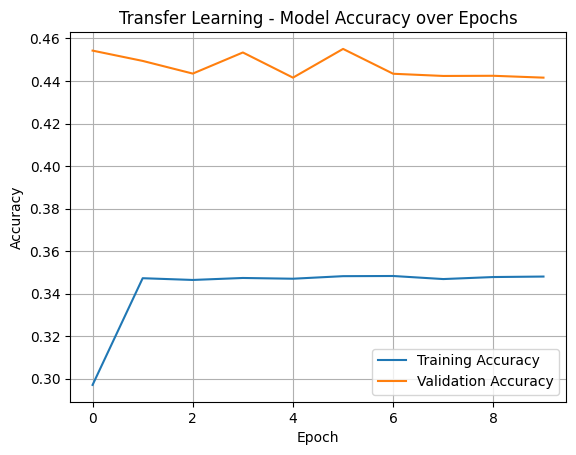

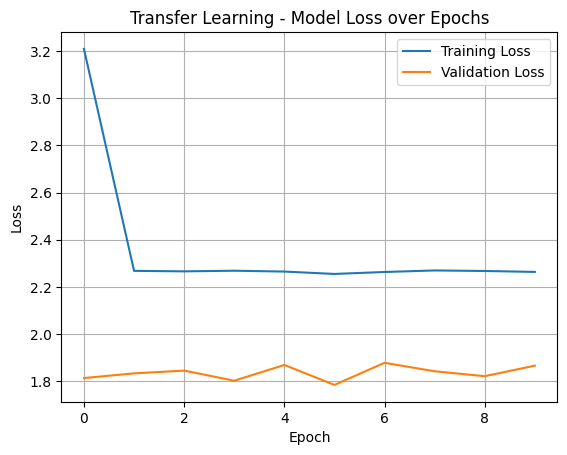

In [83]:
plt.plot(historytf.history['accuracy'], label='Training Accuracy')
plt.plot(historytf.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning - Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(historytf.history['loss'], label='Training Loss')
plt.plot(historytf.history['val_loss'], label='Validation Loss')
plt.title('Transfer Learning 128x128 - Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Modeltf1: Transfer Learning - 128x128 with Data Augmentation and unfreezing the last two layers


In [84]:
# Define constants
IMAGE_SIZE_TRANSFERLEARNING1 = (128, 128) #Image size of 128 x 128
BATCH_SIZE_TF1 = 32
DATASET_PATH = "hagridset"
SEED = 399177 #G00399177

In [85]:
train_datasettf1 = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE_TRANSFERLEARNING1, validation_split=0.3
                                                           , subset='training', label_mode='categorical', 
                                                           seed=SEED, batch_size=BATCH_SIZE_TF1)
NUM_CLASSES_TF = len(train_datasettf1.class_names)
CLASS_NAMES_TF = train_datasettf1.class_names

validation_and_test_datasettf1 = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE_TRANSFERLEARNING1, validation_split=0.3
                                                           , subset='validation',label_mode='categorical',
                                                           seed=SEED, batch_size=BATCH_SIZE_TF1)

val_batchestf1 = tf.data.experimental.cardinality(validation_and_test_datasettf1)

test_datasettf1 = validation_and_test_datasettf1.take((2*val_batchestf1) // 3)

validation_datasettf1 = validation_and_test_datasettf1.skip((2*val_batchestf1) // 3)

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [86]:
data_augmentation_layerstf1 = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

In [87]:
inputs1 = tf.keras.Input(shape=(IMAGE_SIZE_TRANSFERLEARNING1[0], IMAGE_SIZE_TRANSFERLEARNING1[1],3))

In [88]:
model_transferlearning1 = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMAGE_SIZE_TRANSFERLEARNING1[0], IMAGE_SIZE_TRANSFERLEARNING1[1],3),
    include_top=False)

# Unfreeze the last 2 layers for fine tuning
for layer in model_transferlearning1.layers[:-2]:
    layer.trainable = False
for layer in model_transferlearning1.layers[-2:]:
    layer.trainable = True

x = data_augmentation_layerstf1(inputs1)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = model_transferlearning1(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs1 = tf.keras.layers.Dense(NUM_CLASSES_TF)(x)
modeltf1 = tf.keras.Model(inputs1, outputs1)

In [89]:
modeltf1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [90]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [91]:
historytf1 = modeltf1.fit(train_datasettf1,  validation_data=(validation_datasettf1), epochs=10, callbacks=[callback])

Epoch 1/10
2755/2755 [==============================] - 180s 65ms/step - loss: 1.4258 - accuracy: 0.5603 - val_loss: 0.8209 - val_accuracy: 0.7288
Epoch 2/10
2755/2755 [==============================] - 180s 65ms/step - loss: 1.0062 - accuracy: 0.6700 - val_loss: 0.6994 - val_accuracy: 0.7737
Epoch 3/10
2755/2755 [==============================] - 178s 65ms/step - loss: 0.9336 - accuracy: 0.6932 - val_loss: 0.6524 - val_accuracy: 0.7880
Epoch 4/10
2755/2755 [==============================] - 178s 64ms/step - loss: 0.8854 - accuracy: 0.7093 - val_loss: 0.6872 - val_accuracy: 0.7854
Epoch 5/10
2755/2755 [==============================] - 179s 65ms/step - loss: 0.8519 - accuracy: 0.7211 - val_loss: 0.6658 - val_accuracy: 0.7908
Epoch 6/10
2755/2755 [==============================] - 182s 66ms/step - loss: 0.8277 - accuracy: 0.7273 - val_loss: 0.6680 - val_accuracy: 0.7888
Epoch 7/10
2755/2755 [==============================] - 178s 64ms/step - loss: 0.8025 - accuracy: 0.7351 - val_loss: 0

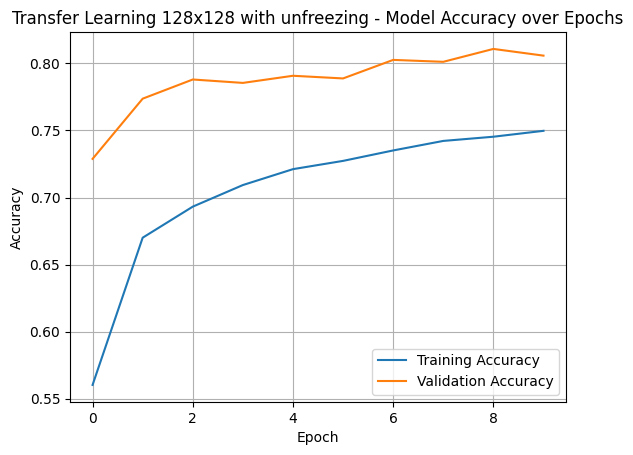

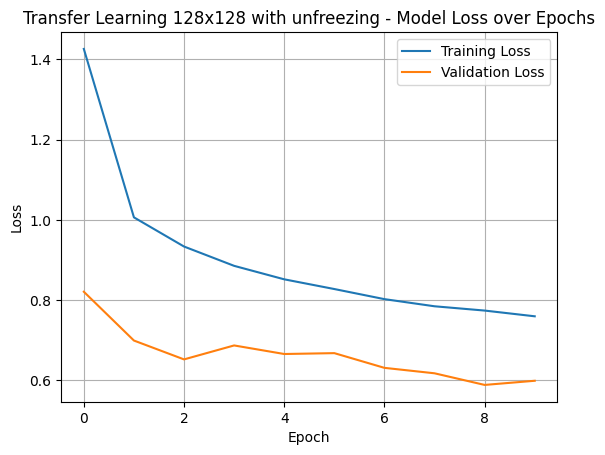

In [96]:
plt.plot(historytf1.history['accuracy'], label='Training Accuracy')
plt.plot(historytf1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning 128x128 with unfreezing - Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(historytf1.history['loss'], label='Training Loss')
plt.plot(historytf1.history['val_loss'], label='Validation Loss')
plt.title('Transfer Learning 128x128 with unfreezing - Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Best Model
Taking into account all the accuracy, loss, and training time metrics, the best model for this task appears to be the CNN from scrath Model1

In [102]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 48)       

### Evaluating the best model on test data

In [101]:
model1.evaluate(test_dataset1, return_dict=True)

787/787 [==============================] - 6s 8ms/step - loss: 0.4993 - accuracy: 0.8420


{'loss': 0.4993378818035126, 'accuracy': 0.8420028686523438}

### Testing the best model on unseen images taken by myself making hand gestures

In [97]:
class_names = train_dataset1.class_names

# Prediction of My Hand Peace
my_image1 = np.array(Image.open("MyHandPeace.jpg").resize((IMAGE_SIZE1[0],IMAGE_SIZE1[1])))
my_image1 = my_image1.reshape(1,IMAGE_SIZE1[0],IMAGE_SIZE1[1],3)
prediction_of_my_image = model1.predict(my_image1)
my_image1_prediction = pd.DataFrame(prediction_of_my_image, columns=class_names).idxmax(axis=1).iloc[0]

# Prediction of My hand Palm
my_image2 = np.array(Image.open("MyHandPalm.jpg").resize((IMAGE_SIZE1[0],IMAGE_SIZE1[1])))
my_image2 = my_image2.reshape(1,IMAGE_SIZE1[0],IMAGE_SIZE1[1],3)
prediction_of_my_image = model1.predict(my_image2)
my_image2_prediction = pd.DataFrame(prediction_of_my_image, columns=class_names).idxmax(axis=1).iloc[0]

# Prediction of My Hand Stop 
my_image3 = np.array(Image.open("MyHandStop.jpg").resize((IMAGE_SIZE1[0],IMAGE_SIZE1[1])))
my_image3 = my_image3.reshape(1,IMAGE_SIZE1[0],IMAGE_SIZE1[1],3)
prediction_of_my_image = model1.predict(my_image3)
my_image3_prediction = pd.DataFrame(prediction_of_my_image, columns=class_names).idxmax(axis=1).iloc[0]

# Prediction of My Hand Two Up
my_image4 = np.array(Image.open("MyHandTwoUp.jpg").resize((IMAGE_SIZE1[0],IMAGE_SIZE1[1])))
my_image4 = my_image4.reshape(1,IMAGE_SIZE1[0],IMAGE_SIZE1[1],3)
prediction_of_my_image = model1.predict(my_image4)
my_image4_prediction = pd.DataFrame(prediction_of_my_image, columns=class_names).idxmax(axis=1).iloc[0]

# Print the predicted class names
print("Predicted Class for MyHandPeace.jpg   (Should predict peace): ", my_image1_prediction)
print("Predicted Class for MyHandPalm.jpg     (Should predict Palm): ", my_image2_prediction)
print("Predicted Class for MyHandStop.jpg     (Should predict Stop): ", my_image3_prediction)
print("Predicted Class for MyHandTwoUp.jpg  (Should predict Two Up): ", my_image4_prediction)

1/1 [==============================] - 0s 12ms/step
Predicted Class for MyHandPeace.jpg   (Should predict peace):  peace
Predicted Class for MyHandPalm.jpg     (Should predict Palm):  palm
Predicted Class for MyHandStop.jpg     (Should predict Stop):  stop
Predicted Class for MyHandTwoUp.jpg  (Should predict Two Up):  two_up
